In [55]:
### Generate dataset from MT5

In [85]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime
import subprocess
import os

# === Step 1: Connect to MT5
print("[...] Initializing MetaTrader 5")
if not mt5.initialize():
    print("[✗] MT5 Initialization failed:", mt5.last_error())
    quit()

symbol = "XAUUSD"
if not mt5.symbol_select(symbol, True):
    print(f"[✗] Failed to select {symbol}")
    mt5.shutdown()
    quit()

# === Step 2: Fetch and save data
print("[...] Fetching data from MT5...")
rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M1, 0, 4000)
df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")

# Save to CSV
csv_file = "xauusd_data.csv"
df.to_csv(csv_file, index=False)
print(f"[✓] Data saved to `{csv_file}`")

# Show last few rows
print("\n[✓] Last 5 rows of data:")
print(df.tail())

# Show last 350 close prices as comma-separated integers
print("\n[📊] Last 600 closing prices (copy-paste ready):")
last_600 = ",".join([str(int(val)) for val in df["close"].tail(600)])
print(last_600)

# === Step 3: Disconnect from MT5
mt5.shutdown()

# === Step 4: Git commit & push if changes exist
print("\n[→] Checking for changes in Git...")
try:
    # Stage the updated CSV
    subprocess.run(["git", "add", csv_file], check=True)

    # Check if there's anything staged to commit
    diff_check = subprocess.run(["git", "diff", "--cached"], capture_output=True, text=True)
    if diff_check.stdout.strip() == "":
        print("[i] No staged changes to commit.")
    else:
        commit_msg = f"Update xauusd_data.csv - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
        subprocess.run(["git", "commit", "-m", commit_msg], check=True)
        subprocess.run(["git", "push"], check=True)
        print(f"[✓] CSV pushed to GitHub with message: '{commit_msg}'")

except subprocess.CalledProcessError as e:
    print(f"[✗] Git error: {e}")


[...] Initializing MetaTrader 5
[...] Fetching data from MT5...
[✓] Data saved to `xauusd_data.csv`

[✓] Last 5 rows of data:
                    time     open     high      low    close  tick_volume  \
3995 2025-07-07 17:08:00  3329.62  3329.97  3329.03  3329.05          148   
3996 2025-07-07 17:09:00  3329.05  3329.73  3328.95  3329.73          126   
3997 2025-07-07 17:10:00  3329.73  3330.74  3329.70  3330.17          139   
3998 2025-07-07 17:11:00  3330.17  3330.90  3330.17  3330.69          124   
3999 2025-07-07 17:12:00  3330.68  3330.68  3330.68  3330.68            1   

      spread  real_volume  
3995      12            0  
3996      12            0  
3997      12            0  
3998      12            0  
3999      12            0  

[📊] Last 600 closing prices (copy-paste ready):
3312,3311,3310,3310,3311,3311,3311,3311,3310,3310,3310,3309,3310,3310,3311,3311,3312,3310,3310,3309,3309,3310,3309,3309,3309,3309,3308,3308,3308,3307,3307,3306,3305,3304,3304,3304,3304,3302,3302

###import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime

# Connect to MetaTrader 5
if not mt5.initialize():
    print("MT5 Initialization failed:", mt5.last_error())
    quit()

# Set symbol
symbol = "XAUUSD"

# Ensure symbol is available
if not mt5.symbol_select(symbol, True):
    print(f"Failed to select {symbol}")
    mt5.shutdown()
    quit()

# Get last 1000 1-minute candles
rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M1, 0, 1000)

# Convert to DataFrame
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# Show last few rows
print(df.tail())

# Save for training
df.to_csv("xauusd_data.csv", index=False)

# Disconnect
mt5.shutdown()




In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import joblib
import os

In [76]:
# === Step 1: Load and explore the dataset
df = pd.read_csv("xauusd_data.csv")

In [77]:
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,2025-07-02 15:04:00,3343.14,3343.24,3342.65,3342.81,132,12,0
1,2025-07-02 15:05:00,3342.81,3343.76,3342.63,3342.81,121,12,0
2,2025-07-02 15:06:00,3342.81,3343.13,3342.32,3342.34,137,12,0
3,2025-07-02 15:07:00,3342.35,3342.89,3342.22,3342.87,110,12,0
4,2025-07-02 15:08:00,3342.87,3343.03,3342.14,3342.17,125,12,0


3310,3310,3310,3310,3310,3310,3310,3309,3309,3308,3307,3308,3308,3308,3307,3308,3307,3308,3310,3311,3312,3311,3310,3311,3312,3311,3311,3311,3311,3311,3310,3310,3311,3311,3311,3312,3312,3310,3310,3309,3309,3310,3309,3309,3309,3309,3309,3309,3309,3307,3307,3307,3305,3305,3305,3304,3304,3303,3303,3302,3302,3302,3303,3303,3301,3302,3302,3302,3303,3303,3302,3302,3302,3303,3304,3305,3305,3305,3306,3306,3306,3307,3307,3308,3308,3308,3307,3307,3308,3309,3309,3310,3309,3310,3310,3310,3310,3311,3311,3311,3312,3311,3311,3313,3311,3310,3311,3310,3311,3310,3311,3310,3310,3310,3311,3310,3311,3309,3309,3309,3309,3309,3309,3309,3310,3310,3310,3310,3311,3311,3311,3311,3311,3311,3311,3311,3311,3311,3311,3311,3311,3310,3310,3309,3309,3309,3309,3310,3309,3309,3309,3309,3310,3310,3310,3309,3308,3307,3307,3308,3308,3307,3307,3306,3307,3308,3309,3309,3309,3309,3309,3309,3308,3309,3309,3309,3308,3310,3310,3309,3309,3310,3310,3309,3309,3309,3309,3310,3310,3309,3309,3309,3309,3309,3308,3308,3309,3310,3309,3309,

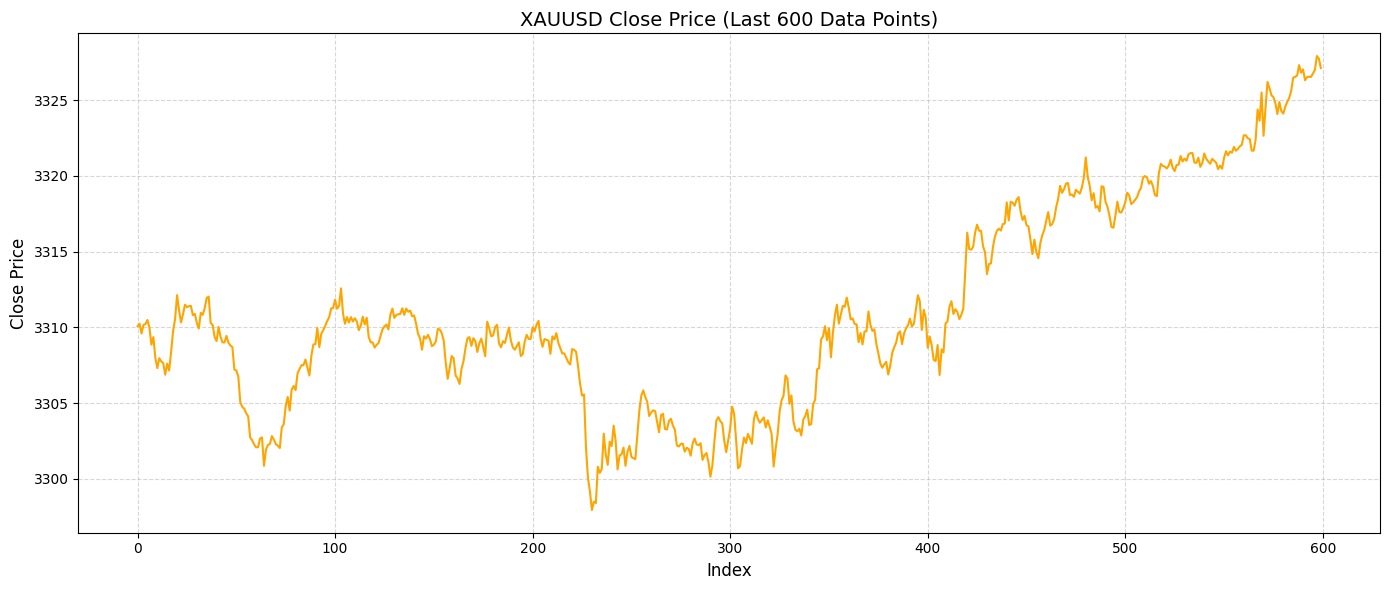

In [80]:
import matplotlib.pyplot as plt

# ✅ Ensure 'close' column is numeric and drop invalid values
df["close"] = pd.to_numeric(df["close"], errors="coerce")
df = df.dropna(subset=["close"])

# ✅ Extract last 600 valid close prices
last_n = 600
last_600 = df["close"].tail(last_n).reset_index(drop=True).to_frame()

# ✅ Optional: Print comma-separated prices as integers
safe_prices = ",".join([str(int(round(val))) for val in last_600["close"]])
print(safe_prices)

# ✅ Plotting
plt.figure(figsize=(14, 6))
plt.plot(last_600["close"], color='orange', linewidth=1.5)

plt.title(f"XAUUSD Close Price (Last {last_n} Data Points)", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Optional: Save to file
# plt.savefig("xauusd_close_plot.png", dpi=300)

plt.show()


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         4000 non-null   object 
 1   open         4000 non-null   float64
 2   high         4000 non-null   float64
 3   low          4000 non-null   float64
 4   close        4000 non-null   float64
 5   tick_volume  4000 non-null   int64  
 6   spread       4000 non-null   int64  
 7   real_volume  4000 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 250.1+ KB


In [62]:
# === Step 1: Load and clean the dataset ===
df = pd.read_csv("xauusd_data.csv")
df['time'] = pd.to_datetime(df['time'])

In [63]:
# Focus on 'close' column
close_data = df['close'].values.reshape(-1, 1)

In [64]:
# === Step 2: Normalize the data ===
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_data)

In [65]:
# === Step 3: Create 600-step sequences for XGBoost ===
def create_sequences(data, window=600):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window=600)

In [66]:
# === Step 4: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [67]:
# === Step 5: Train XGBoost model ===
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [68]:
# === Step 6: Save model + scaler ===
os.makedirs("models", exist_ok=True)
xgb_model.save_model("models/xgboost_model.json")
joblib.dump(scaler, "models/scaler.pkl")

print("✅ XGBoost model and scaler saved in /models")

✅ XGBoost model and scaler saved in /models


In [69]:
from fastapi import FastAPI, Request, Query
from fastapi.templating import Jinja2Templates
from fastapi.responses import HTMLResponse, JSONResponse
from fastapi.middleware.cors import CORSMiddleware
from app.forecast_logic import forecast_next
from pydantic import BaseModel
from typing import List, Optional

app = FastAPI(
    title="XAUUSD Forecast API",
    description="AI-powered forecast and trading signal generator for gold (XAUUSD) using XGBoost.",
    version="1.0.0"
)

# HTML template directory
templates = Jinja2Templates(directory="templates")

# CORS middleware setup (Allow all origins for dev; restrict in production)
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Change to ["https://yourdomain.com"] in production
    allow_methods=["*"],
    allow_headers=["*"]
)

# Input schema for closing prices
class PriceInput(BaseModel):
    close_prices: List[float]

# Root route for rendering frontend UI
@app.get("/", response_class=HTMLResponse)
def read_root(request: Request):
    return templates.TemplateResponse("index.html", {"request": request})

# Health check route
@app.get("/ping")
def ping():
    return {"status": "ok"}

# Prediction route with optional threshold
@app.post("/predict")
def predict(input: PriceInput, threshold: Optional[float] = Query(0.002, ge=0, le=1)):
    """
    Forecast next gold price and trading signal.
    Accepts last 60 close prices and an optional threshold for signal sensitivity.
    """
    try:
        result = forecast_next(input.close_prices, threshold)
        return JSONResponse(content=result)
    except ValueError as ve:
        return JSONResponse(content={"error": str(ve)}, status_code=422)
    except Exception as e:
        return JSONResponse(content={"error": "Server error", "details": str(e)}, status_code=500)


In [70]:
import numpy as np
import joblib
import xgboost as xgb

# Load XGBoost model and scaler
xgb_model = xgb.XGBRegressor()
xgb_model.load_model("models/xgboost_model.json")
scaler = joblib.load("models/scaler.pkl")

# Signal generator with adjustable threshold
def generate_signal(predicted_price, current_price, threshold=0.002):
    diff_ratio = (predicted_price - current_price) / current_price
    if diff_ratio > threshold:
        return "BUY"
    elif diff_ratio < -threshold:
        return "SELL"
    else:
        return "HOLD"

# Main forecast function
def forecast_next(close_prices: list, threshold: float = 0.002):
    if len(close_prices) < 60:
        raise ValueError("Input must have at least 60 closing prices.")

    # Prepare the last 60 prices
    recent_data = np.array(close_prices[-60:]).reshape(-1, 1)

    # Scale and reshape
    scaled = scaler.transform(recent_data)
    X_xgb = scaled.reshape(1, 60)

    # Predict next scaled value
    xgb_pred = xgb_model.predict(X_xgb)
    predicted_scaled = xgb_pred[0]

    # Inverse scale to get real price
    predicted_price = scaler.inverse_transform([[predicted_scaled]])[0][0]

    # Extract current price
    current_price = close_prices[-1]

    # Generate buy/sell/hold signal
    signal = generate_signal(predicted_price, current_price, threshold)

    # TP & SL logic (buffer = 0.5%)
    buffer = 0.005
    if signal == "BUY":
        tp = predicted_price * (1 + buffer)
        sl = predicted_price * (1 - buffer)
    elif signal == "SELL":
        tp = predicted_price * (1 - buffer)
        sl = predicted_price * (1 + buffer)
    else:  # HOLD
        tp = sl = predicted_price

    # Final response
    return {
        "predicted_price": round(predicted_price, 3),
        "current_price": round(current_price, 3),
        "signal": signal,
        "take_profit": round(tp, 3),
        "stop_loss": round(sl, 3)
    }
